# Pose Detection

In this training, we are going to try to detect the position of a person's arms, hands, legs, and feet, from an input image. This is called pose detection. We use a model called the "OpenPose" model, which can detect up to 10 people in an image. 

## Imports

Let's start by loading in all the functionality we are going to need later. It is considered good style to put all of your imports at the beginning, so that's what we do. The comments explain what we use each import for.

In [6]:
import os                         # used to execute bash commands to download and uncompress stuff
import cv2                        # OpenCV image processing library
import numpy as np                # For math
import matplotlib.pyplot as plt   # For plotting stuff
from pynq_dpu import DpuOverlay   # Overlay for the FPGA
import IPython.display            # For displaying a live feed of video


## FPGA Overlays

We run the model on specialized hardware that will allow it to execute faster than on a regular processor. The fastest option would be if we could build custom hardware -- a specialized electronic circuit -- that performs exactly the computations we need. However, soldering your own circuits is hard and takes a lot of time. Also, once such a specialized circuit is built, it can only be used for one thing -- the specific thing it was built for.

FPGAs are the next best thing. They are like circuits, but instead of having to solder them physically, the different electrical connections can be "programmed". FPGAs consist of a large number of gates that we can use to route electricity (which we use to encode data) different ways. This is different from "normal" processor programming: Regular processors read a stream of instructions (our program) and execute those instructions. On FPGAs, we configure a circuit once ahead of time, and can then use it to perform the function it was designed to do multiple times very quickly. The KRIA SoM comes with an FPGA. 

Engineering these FPGA circuits is hard. For this reason, we will use a circuit somebody else already built for us! This is called an "overlay". The circuit we will use allows us to do lightning-fast data processing. This is exactly what we need to perform machine learning inference. Let us first load this circuit. By running the following step, you will configure the electronic circuit on your FPGA as a data processing unit (DPU):

In [7]:
overlay = DpuOverlay("dpu.bit")

**Note:** If you run into a "Device or resource busy" error, quit all your Jupyter notebook kernels and restart this one. Then, try again. You can quit notebook kernels by clicking Kernel > Shutdown and restart by clicking Kernel > Restart.

## AI Model Download

How ML models work internally is not super important to us as users of the models. What we need to know is that these models take an input matrix, perform some calculations, and produce an output matrix of potentially a different dimension.

What the meaning of the input and output matrices is depends on the model. In our model, the input matrix represents an image: Each cell in the matrix can be thought of as a pixel -- a red/green/blue color value at that coordinate in the image. The model outputs many matrices, which can be interpreted as probabilities that a limb is present in a certain pixel.

When models are built, they are "trained" on a large set of input data. This simply means that the coefficients of the calculations are optimized. In order to run the model on our FPGA overlay, some additional modifications are required. Someone has already done this for us, so we only have to download the model.

We download the model from the URL listed in the Model Zoo YAML file. Make sure to use the v2.5 branch; v2.0 will crash the notebook. The model can be used straight from the download without any compilation.

This model expects input of dimensions 368x368.

In [8]:
archive_filename = "openpose_pruned_0_3.tar.gz"
extracted_model_path = "openpose_pruned_0_3.xmodel"

In [9]:
# The following will download the model if it is not already present in the folder:
# model_download_url = "https://www.xilinx.com/bin/public/openDownload?filename=openpose_pruned_0_3-zcu102_zcu104_kv260-r2.5.0.tar.gz"
# os.system("wget -nv -O \"{}\" \"{}\"".format(archive_filename, model_download_url))
# os.system("tar -xvf \"{}\"".format(archive_filename))

## Load Model Onto Overlay


In [10]:
overlay.load_model(extracted_model_path)

## Load an Image

To test the model, let's load an image of a crowd and see if the model can detect the pose of people in it.

The model works on matrices of size 800 x 1000. So first, we need to get our input into the right format. We load a JPEG, decompress it into its raw pixel values, remove the color information and put each pixel value on a 0 - 1 scale. Since the input image also does not exactly match the 800 x 1000 format expected by the model, we crop it slightly. We use the OpenCV library which provides functions to do this necessary processing on the image.

_Image: Sydney International Tennis ATP, licensed CC-BY-SA 2.0._

In [11]:
# The test image should have been shipped with this notebook; if not, download it like so:
# img_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/83/Sydney_International_Tennis_ATP_%2833040179108%29.jpg/640px-Sydney_International_Tennis_ATP_%2833040179108%29.jpg"
# os.system("wget -nv -O test_image.jpeg {}".format(img_url))

The image shows with distorted colors because CV2 reads as BGR but matplotlib expects RGB. We don't convert because the OpenPose model expects BGR too.

(640, 427, 1.4988290398126465, <matplotlib.image.AxesImage at 0xffff5f1c8070>)

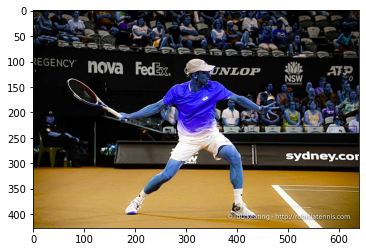

In [12]:
img = cv2.imread("img/test_image.jpeg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Need BGR for OpenPose
height, width = img.shape[0], img.shape[1]
aspect_ratio = width / height
width, height, aspect_ratio, plt.imshow(img)

## Prepare the DPU

Different models have different input and output sizes. Let us see what the expected dimensions are for this model.

In [13]:
dpu = overlay.runner

inputTensors = dpu.get_input_tensors()
outputTensors = dpu.get_output_tensors()

shapeIn = tuple(inputTensors[0].dims)
shapeOut = tuple(outputTensors[0].dims)
outputSize = int(outputTensors[0].get_data_size() / shapeIn[0])
shapeIn, shapeOut, outputSize

((1, 368, 368, 3), (1, 46, 46, 26), 55016)

## Adjust the Image

As we can see, we need an image that has different dimensions than our image we read in previously. To address this, let's pad the image on top and bottom a little:

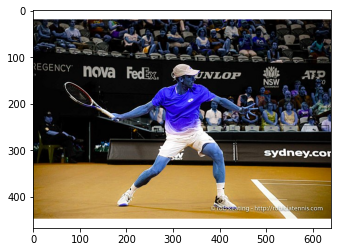

In [14]:
xpad = 0
ypad = 20
canvas = 255*np.ones((height+2*ypad, width+2*xpad, 3), dtype=img.dtype)
canvas[ypad:height+ypad, xpad:width+xpad, :] = img
img = canvas
plt.imshow(canvas)

Now, let's resize and crop it to get the corrected dimensions:

(<matplotlib.image.AxesImage at 0xffff5ee76080>, (368, 368, 3))

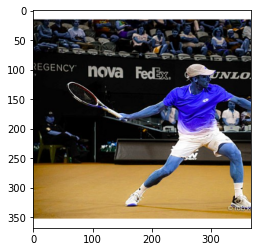

In [15]:
new_height = shapeIn[1]
img_resized = cv2.resize(img, 
                         (int(aspect_ratio*new_height),   # new width; maintain aspect ratio
                          new_height))                    # new height
img_cropped = img_resized[0:shapeIn[1],0:shapeIn[2],:].reshape((shapeIn[1],shapeIn[2],3))
img_cropped = img_cropped.astype(np.float32) / 255.0  # Make it floats
plt.imshow(img_cropped), img_cropped.shape

## Run the Model

Now that the model is loaded, the DPU is ready, and the image has been properly prepared, there's nothing stopping us from running the model!

In [16]:
# Prepare an array of zeros with the correct output dimensions; the DPU will fill in the results in here, but we 
# have to prepare some space for it.
output_data = [np.zeros(shapeOut, dtype=np.float32, order="C")]

# We will be putting our image into this array:
input_data = [np.zeros(shapeIn, dtype=np.float32, order="C")]
# ... but first, we must adjust the shape of the matrix slightly ...
processed_image = img_cropped
processed_image = processed_image.reshape(shapeIn).astype(np.float32, order="C")
input_data[0] = processed_image

# Now, we can send our input to the model ...
job_id = dpu.execute_async(input_data, output_data)
# ... and wait for it to be done doing its calculation
dpu.wait(job_id)

# Now, the results are in output_data

0

But did it work? Let's plot the output of the model!

The model will output several matrices. One of those is a heat map that gives the probabilities that a limb is present at a certain coordinate. A value close to 1 will indicate that the model thinks there is a limb in that model. For now, we will just take the max of these matrices to get an iteresting output. This causes us to lose some information, i.e. which limb the model detected, but it gives us something interesting to look at.

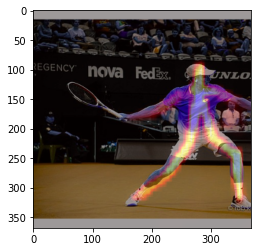

In [17]:
plt.imshow(img_cropped)
heatmap = np.squeeze(np.max(output_data[0][0][:][:][:],axis=2))
heatmap = cv2.resize(heatmap, (shapeIn[2], shapeIn[1]))
plt.imshow(heatmap, cmap='hot', interpolation='nearest', alpha=0.4)

Looking good! For some reason, the model does not seem to detect the right arm, but it detected the other limbs accurately. AI is not perfect -- you are going to see that in your own experiments too.

## Put it all in functions

Next, we will try to apply the model to a live video feed. For this, let us first take all the stuff we programmed above, and put it into functions so we can reuse it without having to repeat ourselves.

In [18]:
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # Need BGR for OpenPose

    # Get dimensions
    height, width = img.shape[0], img.shape[1]
    aspect_ratio = width / height
    width, height, aspect_ratio, plt.imshow(img)
    
    # Padding
    xpad = 0
    ypad = 20
    canvas = 255*np.ones((height+2*ypad, width+2*xpad, 3), dtype=img.dtype)
    canvas[ypad:height+ypad, xpad:width+xpad, :] = img
    img = canvas
    
    # Crop
    new_width = shapeIn[1]
    img_resized = cv2.resize(img, (int(aspect_ratio*new_width), new_width))
    img_cropped = img_resized[0:shapeIn[1],0:shapeIn[2],:].reshape((shapeIn[1],shapeIn[2],3))
    img_cropped = img_cropped.astype(np.float32) / 255.0  # Make it floats
    
    return img_cropped

def run_model(img_cropped):
    processed_image = img_cropped
    processed_image = processed_image.reshape(shapeIn).astype(np.float32, order="C")
    output_data = [np.zeros(shapeOut, dtype=np.float32, order="C")]
    input_data = [np.zeros(shapeIn, dtype=np.float32, order="C")]
    input_data[0] = processed_image
    job_id = dpu.execute_async(input_data, output_data)
    dpu.wait(job_id)
    return output_data[0]

## Getting a live video feed

To test webcam: ffplay /dev/video0

You may have to re-run the first code block if it can't open the camera.

In [19]:
# Setup
capture = cv2.VideoCapture(0)  # Get a handle on the camera; if you have multiple cameras, you can use different indices
capture.set(cv2.CAP_PROP_BUFFERSIZE, 1)  # Disable buffering
capture.set(3, shapeIn[1])   # set input width
capture.set(4, shapeIn[2])   # set input height
n_frames = 5

[ WARN:0@151.437] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@151.438] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range


After initial setup above, let's do the same processing we did above for ten frames in a row. We will show each frame after the model has run.

In [20]:
for i in range(n_frames):
    success, newimg = capture.read()
    if not success:
        print("Error reading webcam image.")
        break
    img_cropped = preprocess_image(newimg)
    output = run_model(img_cropped)
    plt.imshow(img_cropped)
    heatmap = np.squeeze(np.max(output[0][:][:][:],axis=2))
    heatmap = cv2.resize(heatmap, (shapeIn[2], shapeIn[1]))
    plt.imshow(heatmap, cmap='hot', interpolation='nearest', alpha=0.4)
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf())

Error reading webcam image.


## Conclusion and Extra Challenge

This looks pretty good! What uses for this model can you think of?

If you have gotten this far with time left over, try to derive the X/Y coordinates of all limbs from the heatmap. This is harder than it seems! Hint: You will have to write code that detects local maxima, that is, find coordinates in the output matrix where all surrounding values are lower than the value you are looking at; this is a local maximum.